# Tracking COVID19 Using XY.ai Analytic Tools and Resources

## Introduction

Coronavirus 19, or COVID-19 / or severe acute respiratory disease 2 (SARS-CoV2, https://www.who.int/emergencies/diseases/novel-coronavirus-2019/technical-guidance/naming-the-coronavirus-disease-(covid-2019)-and-the-virus-that-causes-it) is a respiratory disease that was discovered in Wuhan, China in December, 2019. The virus is thought to spread through droplet transmission, and can result in severe pneumonia and death. While information about the virus is rapidly changing, there are over 100,000 people infected worldwide, and there have been predictions about how quickly the virus will spread (https://www.who.int/news-room/detail/07-03-2020-who-statement-on-cases-of-covid-19-surpassing-100-000).

An important part of determining which populations will be affected and which groups of individuals/communities to prioritize for preventive efforts (encourage handwashing, self-quarantine when appropriate, avoiding public gatherings, etc) is discovering what the comorbidities of a COVID-19 infection are. Currently, it appears as though one of the main risk factors for infection is being older (> 60 years).

In this XY.ai blog post, we will examine the basic epidemiology of COVID-19 in the United States, and then develop a "risk score" based on presumed co-morbidities for COVID-19 infection. Generally, the following can be thought of as risk factors for a viral infection:

<br> Immunosuppression - due to medications and chronic conditions
<br> Respiratory conditions - such as COPD and asthma in older individuals
<br> Smoking - which may compromise lung function and predispose to a respiratory infection
<br> Access to healthcare
<br> Demographics - such as age

Since the epidemiology of COVID-19 is evolving, the risk index will have to evolve with the data.

## The Role of the Environment

The environment is known to affect how infectious diseases spread. For instance, Lyme disease is spread by ticks and follows a very specific geography in the United States. Built environment, which includes how cities and towns are constructed and laid out, can also affect how diseases are spread: if people are closer together or there are more public meeting places, then diseases that can easily spread through respiratory transmission (such as COVID-19) can spread quickly. Understanding how built environment affects disease spread and the progression of a pandemic is every important: using satellite imagry, we may be able to predict where the next hotspots or trouble areas occur during an epidemic or pandemic. XY.ai has used satellite imagry and geospatial analysis to address other public health issues, such as wildfires (https://www.xy.ai/process/how-to-see-wildfires-from-space). 

## Part 1: Plotting Data by State

To start, let's plot the CDC's current COVID-19 data, which is available here (https://www.cdc.gov/coronavirus/2019-ncov/cases-in-us.html). This will give us an idea of which states are hotspots.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
from psycopg2.extras import RealDictCursor
import folium
import pandas as pd
import shapely.wkt
from shapely.geometry import mapping, shape
import geojson
from sqlalchemy import func
from collections import defaultdict
#from IPython.display import IFrame
from IPython.display import display_html
    
############################
### Getting COVID19 Data ###
############################

# We will load the COVID 19 data from a TSV (Tab-separated values) file
# Format: Name (\t) ID (\t) Range (\t) Cases (\t) Reported
covid19data = defaultdict(int)
tfile = "covid19-cdc-10032020.tsv"
with open(tfile, "r") as infile:
    line = infile.readline()
    for line in infile:
        line = line.strip()
        ldata = line.split("\t")
        if len(ldata) > 1:
            tstate = ldata[1].upper().strip()
            trate = ldata[2]
            if ldata[2] == "None":
                trate = 0
            if ldata[2].find('-') > -1:
                rdata = ldata[2].split('-')
                trate = int(rdata[1])
            covid19data[tstate] = trate
            #print("State:" + ldata[0] + "\t" + "Cases Reported: " + ldata[2])
infile.close()


In [2]:
# Now let's take the COVID19 data and plot it on a map:

tJSON = "us-states.json"

# Now make a Pandas dataframe from our previous dictionary:
covid19df = pd.DataFrame(list(covid19data.items()), columns=['id', 'rate'])
#print dataframe to see if data looks okay...
#print(covid19df)

# Initialize the map:
covid19map = folium.Map(location=[35, -100], zoom_start=4.3)
 
# Add the color for the chloropleth:
folium.Choropleth(geo_data=tJSON, name='choropleth', data=covid19df, columns=['id', 'rate'], key_on='feature.id', fill_color='YlOrRd',
 fill_opacity=0.7, line_opacity=0.2, legend_name='COVID19 Cases').add_to(covid19map)

# ... and display the map
covid19map

## Part 2: Finding Regions at Risk Using 500 Cities Data

Now, using the CDC's 500 cities data, we can look into the relationship between several potential risk factors for COVID-19 infection, such as cancer, asthma, COPD, CHD, stroke, smoking, diabetes, and access to healthcare prevalence. For age, we'll use the median age calculated in the US census for each zipcode / census tract. We will bin the age data into child (< 18 years median age), young adult (18-35 years), adult (35-60 years), and seniors (>= 60 years).


In [3]:
def GetDBConnection(tmode):
    
    if tmode == "cdc500":
        # Note: when we publish this blog post, the below data will be changed to localhost/template1/postgres
        hostDB = "xy-ai-server-02-06-2020.ccp7icrordwn.us-east-1.rds.amazonaws.com"
        tDB = "chiraglab"
        tUser = "root"
        tPassword = "wUF9WvjYLbgy3kFJ"
        
    if tmode == 'census':
        #EDB
        hostDB = '104.196.156.226'
        tDB = 'postgres'
        tUser = 'postgres'
        tPassword = 'edb'
    
    #hostDB = "localhost"
    #tDB = "template1"
    #tUser = "postgres"
    #tPassword = ""
    conn = psycopg2.connect(host=hostDB, database=tDB, user=tUser, password=tPassword)
    cur = conn.cursor(cursor_factory=RealDictCursor)    
    return conn, cur


######################################
### Getting 500 Cities Data - 2013 ###
######################################

# Connect to database and store in dictionary
conn, cur = GetDBConnection('cdc500')

# Let's get the 500 Cities data stored in the database using an SQL query
diseaselist = ["CANCER_CrudePrev", "STROKE_CrudePrev", "ACCESS2_CrudePrev", "CASTHMA_CrudePrev", "COPD_CrudePrev", "CHD_CrudePrev", "OBESITY_CrudePrev", "CSMOKING_CrudePrev", "DIABETES_CrudePrev"]
tcollist = '"{0}"'.format('", "'.join(diseaselist))
tsql = 'Select ' + tcollist + ', stateabbr, placename, "Geolocation", population_2010, fips_place_tract, fips_tract from edw.fivehundredcities_data'
cur.execute(tsql)
cdc500 = cur.fetchall()

# We've finished querying the database, now close the connections
cur.close()
conn.close()

#################################
### Getting Census Data - Age ###
#################################
conn2, cur2 = GetDBConnection('census')
cur2.execute('select b.statefip, b.fipcode, b.geoid, st_area(b.geographywkt), a.shape_id, a.median_household_income, a.median_age from edb_docai.ses_census_tract a inner join edw.shapefile b on (a.shape_id::INTEGER=b.shape_id)')
agedata = cur2.fetchall()
cur2.close()
conn2.close()

# now match fips tract and geoid: left_on='fips_tract', right_on='geoid'
finaltable = defaultdict(lambda: defaultdict(float))
for trow in cdc500:
    ldata = trow['fips_place_tract'].split('-')
    tstate = trow['fips_place_tract'][:2]
    if len(ldata) > 1:
        fipsid = ldata[1]
        # Fix the FIPS ID based on state code:
        if (str(tstate)[0] == "0"):
            fipsid = ldata[1].zfill(11)
        finaltable[fipsid]['stateabbr'] = trow['stateabbr']
        finaltable[fipsid]['placename'] = trow['placename']
        finaltable[fipsid]['population_2010'] = trow['population_2010']
        for x in diseaselist:
            nval = trow[x]
            if nval is None:
                nval = 0
            finaltable[fipsid][x] = nval

# now merge with median age data from census, classify as youth, adult, etc.
tmatch = 0
cChild = 0
cYoungAdult = 1
cAdult = 2
cSenior = 3
for trow in agedata:
    ttract = trow['geoid']
    if ttract in finaltable:
        if trow['median_age'] is not None:
            tage = int(trow['median_age'])
            tclass = "none"
            if tage < 18:
                tclass = cChild
            if (tage >= 18) & (tage <= 35):
                tclass = cYoungAdult
            if (tage > 35) & (tage < 60):
                tclass = cAdult
            if (tage >= 60):
                tclass = cSenior
            if tage is None:
                tage = 0
                tclass = -1
            
            # convert sqm to square km
            tarea = trow['st_area'] / 1000000
            
            # calculate density, etc.
            finaltable[ttract]['income'] = trow['median_household_income']
            finaltable[ttract]['density'] = finaltable[ttract]['population_2010'] / tarea
            finaltable[ttract]['median_age'] = tage
            finaltable[ttract]['median_household_income'] = trow['median_household_income']
            finaltable[ttract]['ageclass'] = tclass
            tmatch += 1


Now let's complete a basic comparison of disease prevalence vs. median age. This will allow us to determine if the disease prevalences are indeed a function of median age as we would expect, with certain chronic conditions increasing as the median age gets older. Here we'll highlight census tracts in red for median age > 60.

<Figure size 432x288 with 0 Axes>

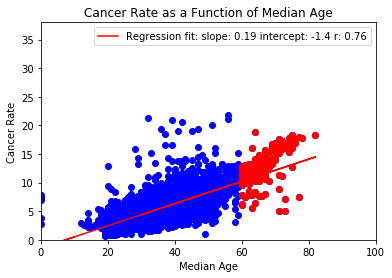

<Figure size 432x288 with 0 Axes>

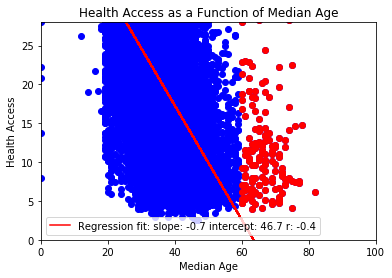

<Figure size 432x288 with 0 Axes>

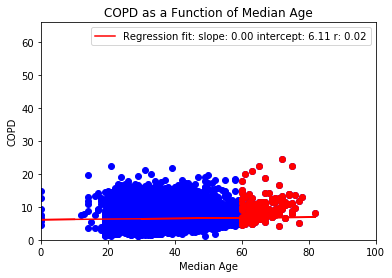

<Figure size 432x288 with 0 Axes>

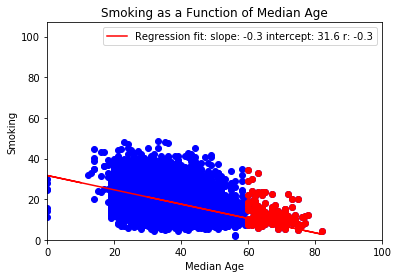

<Figure size 432x288 with 0 Axes>

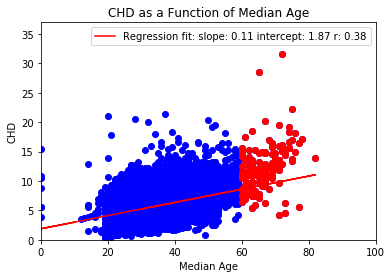

<Figure size 432x288 with 0 Axes>

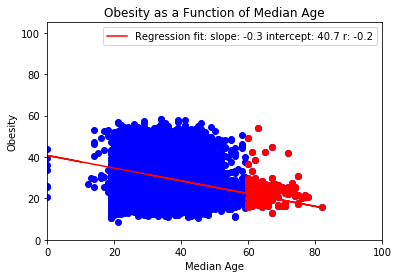

<Figure size 432x288 with 0 Axes>

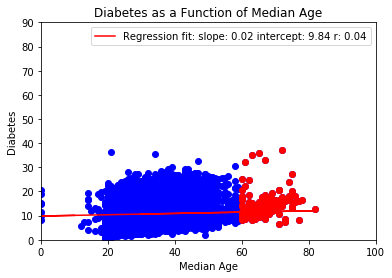

<Figure size 432x288 with 0 Axes>

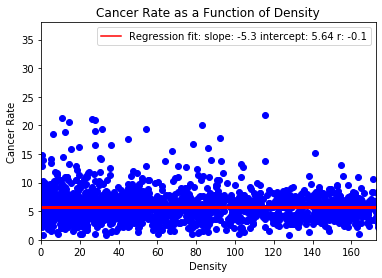

<Figure size 432x288 with 0 Axes>

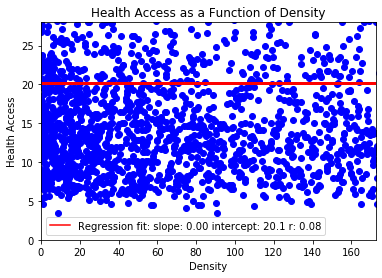

<Figure size 432x288 with 0 Axes>

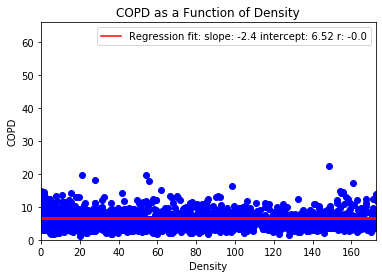

<Figure size 432x288 with 0 Axes>

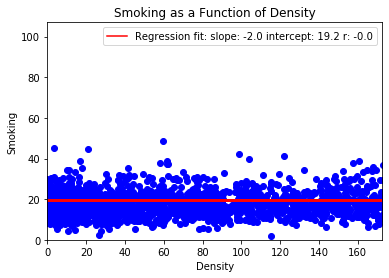

<Figure size 432x288 with 0 Axes>

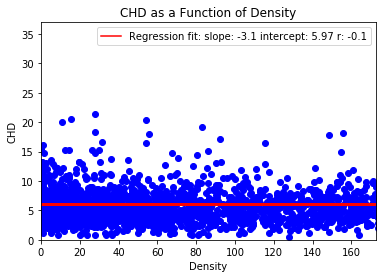

<Figure size 432x288 with 0 Axes>

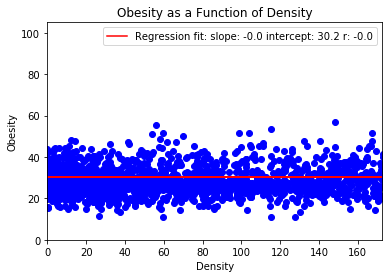

<Figure size 432x288 with 0 Axes>

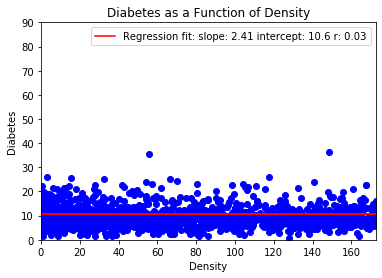

In [10]:
cancervals = np.array([])
strokevals = np.array([])
accessvals = np.array([])
asthmavals = np.array([])
copdvals = np.array([])
chdvals = np.array([])
obesityvals = np.array([])
diabetesvals = np.array([])
smokingvals = np.array([])
agevals = np.array([])
densityvals = np.array([])

for tfips in finaltable:
    cancervals = np.append(cancervals, finaltable[tfips]['CANCER_CrudePrev'])
    strokevals = np.append(strokevals, finaltable[tfips]['STROKE_CrudePrev'])
    accessvals = np.append(accessvals, finaltable[tfips]['ACCESS2_CrudePrev'])
    asthmavals = np.append(asthmavals, finaltable[tfips]['CASTHMA_CrudePrev'])
    copdvals = np.append(copdvals, finaltable[tfips]['COPD_CrudePrev'])
    chdvals = np.append(chdvals, float(finaltable[tfips]['CHD_CrudePrev']))
    obesityvals = np.append(obesityvals, float(finaltable[tfips]['OBESITY_CrudePrev']))
    diabetesvals = np.append(diabetesvals, float(finaltable[tfips]['DIABETES_CrudePrev']))
    smokingvals = np.append(smokingvals, finaltable[tfips]['CSMOKING_CrudePrev'])
    agevals = np.append(agevals, finaltable[tfips]['median_age'])
    densityvals = np.append(densityvals, finaltable[tfips]['density'])

def ShowScatter(xval, yval, xtitle, ytitle, tmode):
    plt.figure()
    ttitle = ytitle + ' as a Function of ' + xtitle
    fig, ax1 = plt.subplots()
    (m, b) = np.polyfit(xval.astype(float), yval.astype(float), 1)
    correlation = np.corrcoef(xval.astype(float), yval.astype(float))[0,1]
    r = correlation
    tforecast = np.append(xval, [10])
    yp = np.polyval([m, b], tforecast)
    plt.plot(tforecast, yp, label="Regression fit: slope: " + str(m)[0:4] + " intercept: " + str(b)[0:4] + " r: " + str(r)[0:4], color='red')
    plt.scatter(xval, yval, c="blue")

    # plot age > 60
    if tmode == "age":
        redX = np.array([])
        redY = np.array([])
        for x in range(0, len(xval)):
            if xval[x] >= 60:
                redX = np.append(redX, xval[x])
                redY = np.append(redY, yval[x])
        plt.scatter(redX, redY, c="red")
    
    yaxismax = ((np.max(yval) % 10) + 2) * 10
    xaxismax = ((np.max(xval) % 10) + 8) * 10
    if xaxismax < 100:
        xaxismax = 100
    plt.xlim(0, xaxismax)
    plt.ylim(0, yaxismax)
    plt.title(ttitle)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.legend()
    plt.show()

# plot prevalence vs. median age
tmode = "age"
ShowScatter(agevals, cancervals, 'Median Age', 'Cancer Rate', tmode)
ShowScatter(agevals, accessvals, 'Median Age', 'Health Access', tmode)
ShowScatter(agevals, copdvals, 'Median Age', 'COPD', tmode)
ShowScatter(agevals, smokingvals, 'Median Age', 'Smoking', tmode)
ShowScatter(agevals, chdvals, 'Median Age', 'CHD', tmode)
ShowScatter(agevals, obesityvals, 'Median Age', 'Obesity', tmode)
ShowScatter(agevals, diabetesvals, 'Median Age', 'Diabetes', tmode)


Having completed the analysis of disease prevalence vs. median age, we can now look at the intercorrelation of disease prevalences, with an emphasis on seniors (>= 60 years of age). We can do this as follows:

            Cancer    Stroke       CHD    Access      COPD  Diabetes   Smoking
Cancer    1.000000  0.188570  0.501249 -0.385292  0.135577  0.116493 -0.641262
Stroke    0.188570  1.000000  0.911060  0.690909  0.921909  0.955614  0.429033
CHD       0.501249  0.911060  1.000000  0.481111  0.878808  0.869477  0.181906
Access   -0.385292  0.690909  0.481111  1.000000  0.728327  0.692306  0.811478
COPD      0.135577  0.921909  0.878808  0.728327  1.000000  0.916814  0.578168
Diabetes  0.116493  0.955614  0.869477  0.692306  0.916814  1.000000  0.478998
Smoking  -0.641262  0.429033  0.181906  0.811478  0.578168  0.478998  1.000000


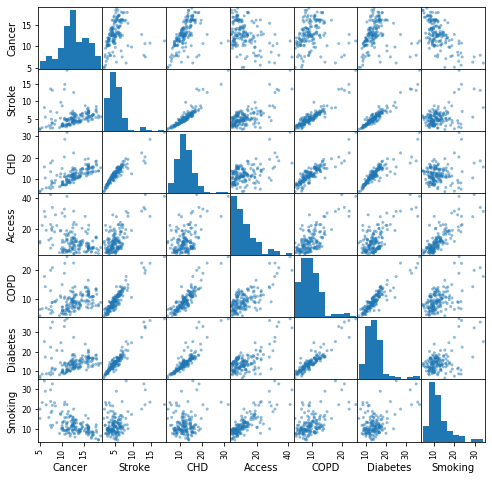

In [5]:
# Now plot low income, asthma, smoking, COPD, access to health care intercorrelations for Washington, California, New York
# for different age bins
cancervals = np.array([])
strokevals = np.array([])
accessvals = np.array([])
asthmavals = np.array([])
copdvals = np.array([])
chdvals = np.array([])
obesityvals = np.array([])
diabetesvals = np.array([])
smokingvals = np.array([])
for tfips in finaltable:
    if (finaltable[tfips]['ageclass'] == cSenior):
        cancervals = np.append(cancervals, finaltable[tfips]['CANCER_CrudePrev'])
        strokevals = np.append(strokevals, finaltable[tfips]['STROKE_CrudePrev'])
        accessvals = np.append(accessvals, finaltable[tfips]['ACCESS2_CrudePrev'])
        asthmavals = np.append(asthmavals, finaltable[tfips]['CASTHMA_CrudePrev'])
        copdvals = np.append(copdvals, finaltable[tfips]['COPD_CrudePrev'])
        chdvals = np.append(chdvals, finaltable[tfips]['CHD_CrudePrev'])
        obesityvals = np.append(obesityvals, finaltable[tfips]['OBESITY_CrudePrev'])
        diabetesvals = np.append(diabetesvals, finaltable[tfips]['DIABETES_CrudePrev'])
        smokingvals = np.append(smokingvals, finaltable[tfips]['CSMOKING_CrudePrev'])

# plot correlations
df = pd.DataFrame({'Cancer': cancervals, 'Stroke': strokevals, 'CHD': chdvals, 'Access': accessvals, 'COPD': copdvals, 'Diabetes': diabetesvals, 'Smoking': smokingvals})
print(df.corr())
pd.plotting.scatter_matrix(df, figsize=(8, 8))
plt.show()


## Part 3: Ranking at Risk Regions based on Chronic Diseases

Now that we've examined the relationships between potential COVID-19 comorbidities, we can put together a simple risk index using a weighted average fo the prevalences of different conditions. We can also test different models by changing the weighting systematically, or using existing evidence-baesd weighting methods. Here's we'll select eight prevalences and take a simple average to start.

In [6]:
# coefficients - can be QALY, DALY, etc.

# specify coefficients based on the diseases / prevalences from diseaselist defined above:
diseasemodel = ["CANCER", "ACCESS2", "CASTHMA", "COPD", "CSMOKING", "CHD", "OBESITY"]
model1 = [2, 2, 1, 1, 1, 0.5, 2.5]
model2 = [4, 0.5, 0.5, 0.5, 2, 0.5, 2]

def CalculateModel(tmodel, diseasemodel, finaltable, densityAdj):

    covidindex = defaultdict(float)
        
    for tfips in finaltable:
        if (finaltable[tfips]['ageclass'] == cSenior):
            for x in range(0, len(diseasemodel) - 1):
                adjcoef = 1
                if densityAdj == "density":
                    adjcoef = finaltable[tfips]['density']
                covidindex[tfips] += (tmodel[x] * float(finaltable[tfips][diseasemodel[x] + "_CrudePrev"])) * adjcoef
            covidindex[tfips] = round(covidindex[tfips] / 10, 2)

    # print out ranking by index:
    trank = 1
    statecnt = defaultdict(int)
    print("Rank\tTract\tScore\tState\tPlace Name")
    for w in sorted(covidindex, key=covidindex.get, reverse=True):
        if trank <= 10:
            print(str(trank) + "\t" + w + "\t" + str(covidindex[w]) + "\t" + finaltable[w]['stateabbr'] + "\t" + finaltable[w]['placename'])
        statecnt[finaltable[w]['stateabbr']] += 1
        trank += 1

    # print out state ranking
    trank = 1
    print("\nState\tNumber of High Risk Census Tracts")
    for tstate in sorted(statecnt, key=statecnt.get, reverse=True):
        if trank <= 5:
            print(tstate + "\t" + str(statecnt[tstate]))
        trank += 1

# get rankings from models
print("Model 1")
CalculateModel(model1, diseasemodel, finaltable, "")
print("\nModel 2")
CalculateModel(model2, diseasemodel, finaltable, "")

print("\nModel 3 - Density Adjusted")
CalculateModel(model1, diseasemodel, finaltable, "density")
print("\nModel 4 - Density Adjusted")
CalculateModel(model2, diseasemodel, finaltable, "density")




Model 1
Rank	Score	State	Place Name
1	17.93	NY	New York
2	17.27	NY	New York
3	16.26	OH	Cleveland
4	15.54	NY	New York
5	15.01	FL	Tampa
6	14.79	OK	Oklahoma City
7	14.76	CA	Long Beach
8	13.48	NY	New York
9	12.9	CA	Pomona
10	12.88	FL	Pembroke Pines

State	Number of High Risk Census Tracts
AZ	41
FL	40
CA	29
NY	14
NV	9

Model 2
Rank	Score	State	Place Name
1	14.41	NY	New York
2	14.18	OH	Cleveland
3	13.67	NY	New York
4	13.57	NY	New York
5	13.43	CA	Long Beach
6	13.19	OK	Oklahoma City
7	12.89	FL	Tampa
8	12.69	FL	Boynton Beach
9	12.44	FL	Largo
10	12.28	PA	Philadelphia

State	Number of High Risk Census Tracts
AZ	41
FL	40
CA	29
NY	14
NV	9

Model 3 - Density Adjusted
Rank	Score	State	Place Name
1	284057.35	NY	New York
2	233650.87	NY	New York
3	162482.46	CA	San Francisco
4	159745.05	NY	New York
5	91772.72	NY	New York
6	81645.6	IL	Chicago
7	73062.51	NY	New York
8	72568.26	NY	New York
9	66062.07	PA	Philadelphia
10	64250.69	NY	New York

State	Number of High Risk Census Tracts
AZ	41
FL	40
CA	29
NY	14
NV	

## Conclusions

Having generated a very simple risk index, it is possible to extend this preliminary analysis and develop a more rigorous, scientific risk index based on more rigorous scientific evidence, and solid statistical framework, and incorporating geospatial information from the XY.ai platform, which we will do in the next blog post. The slight changes in the coefficients from model 1 to model 2 have shown that while the overall count of at risk census tracts per state has not changed substantially, the ranking of the census tract regions has. By multiplying by population density, we can see major cities then dominate the top 10 of the ranking, with various regions in New York and San Francisco moving up the ranking.

Rankings based on risk indices can help public health and primary care prioritize which areas are going to be disproportionately impacted by COVID-19, and implement preventive measures at the earliest possible time in these regions, which can include increased surveillence, increased resources, and focused educational campaigns.

Using geospatial analysis, it may be possible to not only refine incidence and prevalence rates based on the environment and build environment of urban / rural areas. Geospatial indicators could be used to refine the risk indices we've previously compiled, and help public health offices and health care workers better gauge the risk their patients face.